<a href="https://colab.research.google.com/github/Waidhoferj/CSC-566-Project/blob/apply_filter/FacialLandmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Landmarks
Experimentation with facial landmarks models and datasets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from google.colab import drive
import os
from scipy.io import loadmat
import random

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Add your name and filepath to the project folder so that you can load the datasets.


In [18]:
USER = "Ty"
USER_FILEPATHS = {
    "John" : "/content/drive/MyDrive/CSC 566 Project",
    "Jeremy" : "/content/drive/MyDrive/School/Undergrad/2021 Spring/CSC 566/CSC 566 Project",
    "Ty" : "/content/drive/MyDrive/CSC 566 Project"
}
PROJECT_FILEPATH = USER_FILEPATHS[USER]

## Data Preparation

In [9]:
# Sanity check for loading data
def display_landmarks(img, points):
  """
  Displays portrait with landmark dots drawn on the face.
  Assumes that points are in (68,2)
  """
  #If we are reading from .mat files directly (2,68)
  if points.shape[0] == 2:
    points = points.transpose(1,0)
  #If reading from model output
  elif len(points.shape) == 1:
    points = points.reshape(-1,2)
  fig,ax = plt.subplots(1)
  ax.set_aspect('equal')
  ax.imshow(img)
  for p in points:
      circ = Circle(p)
      ax.add_patch(circ)
  plt.show()

#points = loadmat(AFW_DATASET + "/70037463_1.mat")["pt2d"]
#img  = plt.imread( AFW_DATASET+"/70037463_1.jpg")

#display_landmarks(img,points)



In [8]:
import tensorflow as tf

DATALOADER_BASE_PATH = PROJECT_FILEPATH + "/datasets/tf-datasets"
USE_CROPPED_IMAGES = False
DATASET_PREFIX = "cropped-" if USE_CROPPED_IMAGES else ""

class DataLoader:

  IMAGE_SHAPE = (256, 256, 3) if USE_CROPPED_IMAGES else (450, 450, 3)
  LANDMARKS_SHAPE = (136,)

  BATCH_SIZE = 64
  TRAIN_PATHS = [f"{DATALOADER_BASE_PATH}/{DATASET_PREFIX}train-{i}.tfrecord.gz" for i in range(5)]
  VAL_PATHS = [f"{DATALOADER_BASE_PATH}/{DATASET_PREFIX}val-{i}.tfrecord.gz" for i in range(5)]
  TEST_PATHS = [f"{DATALOADER_BASE_PATH}/{DATASET_PREFIX}test-{i}.tfrecord.gz" for i in range(5)]

  def load_datasets():
    dl = DataLoader()
    return (dl.__load_dataset(DataLoader.TRAIN_PATHS, DataLoader.BATCH_SIZE),
            dl.__load_dataset(DataLoader.VAL_PATHS, DataLoader.BATCH_SIZE),
            dl.__load_dataset(DataLoader.TEST_PATHS, 1))

  def __load_dataset(self, filepath, batch_size):
    dataset = tf.data.TFRecordDataset([filepath], compression_type="GZIP")
    dataset = dataset.map(self.__parse_example, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(self.__reshape_entry, num_parallel_calls=tf.data.AUTOTUNE)
    images = dataset.map(lambda x,y: x).batch(batch_size)
    labels = dataset.map(lambda x,y: y).batch(batch_size)
    dataset = tf.data.Dataset.zip((images, labels))
    dataset.cache() # Cache the above map operations so they aren't re-run every epoch
    return dataset


  def __parse_example(self, record):
    feature_names = {}
    feature_names['image'] = tf.io.FixedLenSequenceFeature([],tf.float32, allow_missing=True)
    feature_names['landmarks'] = tf.io.FixedLenSequenceFeature([],tf.float32, allow_missing=True)
    return tf.io.parse_single_example(record, feature_names)

  def __reshape_entry(self, entry):
    image = tf.reshape(entry['image'], DataLoader.IMAGE_SHAPE)
    landmarks = tf.reshape(entry['landmarks'], DataLoader.LANDMARKS_SHAPE)
    return image, landmarks


train_data, val_data, test_data = DataLoader.load_datasets()
for i,record in enumerate(val_data):
  print(record[0].shape)

(64, 450, 450, 3)
(64, 450, 450, 3)
(64, 450, 450, 3)
(58, 450, 450, 3)


## Basic Benchmark Model
From [this medium article](https://towardsdatascience.com/detecting-facial-features-using-deep-learning-2e23c8660a7a)

In [4]:
def create_basic_landmark_model(input_shape, conv_range):
  input_layer = layers.Input(input_shape)
  x = input_layer
  for exp in conv_range:
    x = layers.Conv2D(2**exp, (3,3), 3, activation="relu")(x)
    x = layers.MaxPool2D(padding="same")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(500, activation="relu")(x)
  x = layers.Dense(90, activation="relu")(x)
  x = layers.Dense(68*2, activation="relu")(x)
  return Model(name="landmark_locator", inputs=input_layer, outputs=x)



In [5]:
INPUT_SHAPE = (450,450,3)
basic_model = create_basic_landmark_model(INPUT_SHAPE, range(5,8))
basic_model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
basic_model.summary()

Model: "landmark_locator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 450, 450, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)    

In [ ]:
# Training
history = basic_model.fit(train_data.shuffle(64), epochs=30, validation_data=val_data, verbose=1)

Epoch 1/30
26/26 [==============================] - 23s 160ms/step - loss: 0.0827 - accuracy: 0.2055 - val_loss: 0.0828 - val_accuracy: 0.1920
Epoch 2/30
26/26 [==============================] - 23s 160ms/step - loss: 0.0827 - accuracy: 0.2068 - val_loss: 0.0828 - val_accuracy: 0.1920
Epoch 3/30
26/26 [==============================] - 23s 159ms/step - loss: 0.0826 - accuracy: 0.2055 - val_loss: 0.0828 - val_accuracy: 0.1880
Epoch 4/30
26/26 [==============================] - 23s 159ms/step - loss: 0.0826 - accuracy: 0.2062 - val_loss: 0.0828 - val_accuracy: 0.1920
Epoch 5/30
26/26 [==============================] - 23s 156ms/step - loss: 0.0826 - accuracy: 0.2062 - val_loss: 0.0827 - val_accuracy: 0.1920
Epoch 6/30
26/26 [==============================] - 23s 159ms/step - loss: 0.0825 - accuracy: 0.2055 - val_loss: 0.0827 - val_accuracy: 0.1920
Epoch 7/30
26/26 [==============================] - 23s 159ms/step - loss: 0.0825 - accuracy: 0.2049 - val_loss: 0.0826 - val_accuracy: 0.1920

In [ ]:
basic_model.save_weights(PROJECT_FILEPATH + "/uncropped-basic-weights.h5")

In [6]:
# Running
basic_model.load_weights(PROJECT_FILEPATH + "/uncropped-basic-weights.h5")

### Analyze Results

In [ ]:
pd.DataFrame(basic_model.history.history).plot()

In [ ]:
predictions = basic_model.predict(test_data.map(lambda x,y: x))

In [ ]:
#@title View Predicted Images
image_index = 3 #@param {type:"slider", min:1, max:16, step:1}
points = predictions * 450
i = 0
for x in test_data.map(lambda x,y: x):
#  for img in x:
  if (i == image_index):
    display_landmarks(tf.reshape(x, DataLoader.IMAGE_SHAPE), points[image_index])
    break
  i += 1

#Apply Filter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img: (1, 450, 450, 3) landmarks:(1, 136)


<Figure size 432x288 with 0 Axes>

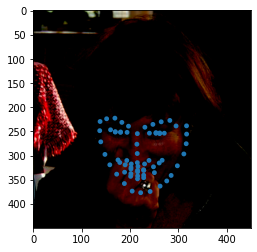

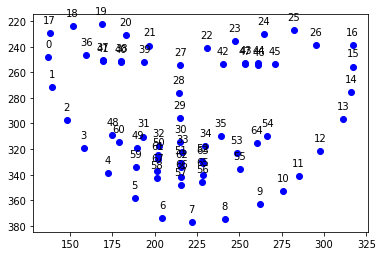

In [10]:
import matplotlib.pyplot as plt
import numpy as np

count = 0
img_size = 450

for img,landmarks in test_data:
  if count == 1:
    break
  #plots the face with landmarks
  print("img: {0} landmarks:{1}".format(img.shape, landmarks.shape))
  plt.clf()

  landmarks = landmarks.numpy().squeeze()
  x_points = landmarks[0::2]
  y_points = landmarks[1::2]

  
  fig,ax = plt.subplots(1)
  ax.set_aspect('equal')
  ax.imshow(img.numpy().squeeze())


  for i in range(len(x_points)):
      circ = Circle((x_points[i]*img_size, y_points[i]*img_size))
      ax.add_patch(circ)
  plt.show()
  
  #annotates the face with numbers
  plt.clf()
  plt.gca().invert_yaxis()  
  for i in range(len(x_points)):
    # 'bo-' means blue color, round points, solid lines
    plt.plot(x_points[i]*img_size,y_points[i]*img_size,'bo-')


    plt.annotate(i, # this is the text
                 (x_points[i]*img_size,y_points[i]*img_size), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
   
  plt.show()

  
  count = count + 1



width: 1024 height: 887
width: 1024 height: 887
width: 1024 height: 887


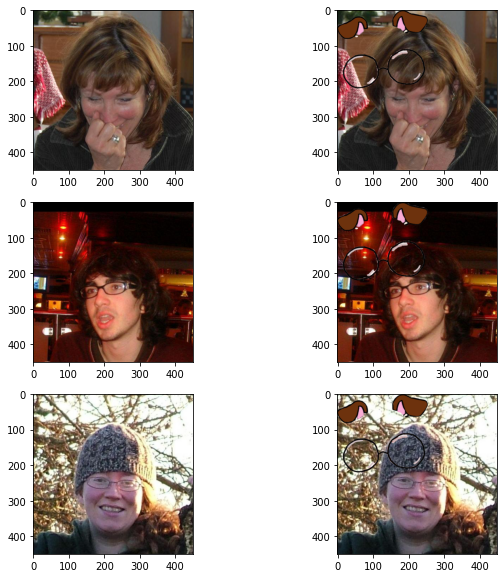

In [91]:
from PIL import Image
filter_path = PROJECT_FILEPATH + "/dog_filter.png"
count = 1
total_count = 3
plt.figure(figsize=(10, 10))
for img,landmarks in test_data:
  if count == total_count + 1:
    break

  rows = total_count
  cols = 2
  plt.subplot(rows,cols, count*2 - 1)

  #landmarks = landmarks.numpy().squeeze()

  foreground = Image.open(filter_path)
  print("width: {0} height: {1}".format(foreground.width, foreground.height))

  foreground = foreground.resize((foreground.width//4, foreground.height//4))
  background = Image.fromarray(np.uint8((img.numpy()[0] + 1)*127.5))

  plt.imshow(background)
  background.paste(foreground, (0,0, foreground.width, foreground.height), foreground)

  plt.subplot(rows,cols, count*2)
  plt.imshow(background)
  count = count + 1

